In [1]:
import sys
sys.path.append("d:/Documents/Projects/autodrive/modules/")

print(sys.path)

from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import pandas as pd
import torch
import os
from torchvision.transforms import CenterCrop, Resize, Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.models
import torch.optim as optim
from tqdm import tqdm
import gc
import numpy as np
from tqdm import tqdm
# from tqdm.contrib.telegram import tqdm
# import myTelebot

['d:\\Documents\\Projects\\autodrive', 'c:\\Users\\ANT-PC\\anaconda3\\envs\\autodrive-env\\python37.zip', 'c:\\Users\\ANT-PC\\anaconda3\\envs\\autodrive-env\\DLLs', 'c:\\Users\\ANT-PC\\anaconda3\\envs\\autodrive-env\\lib', 'c:\\Users\\ANT-PC\\anaconda3\\envs\\autodrive-env', '', 'c:\\Users\\ANT-PC\\anaconda3\\envs\\autodrive-env\\lib\\site-packages', 'c:\\Users\\ANT-PC\\anaconda3\\envs\\autodrive-env\\lib\\site-packages\\win32', 'c:\\Users\\ANT-PC\\anaconda3\\envs\\autodrive-env\\lib\\site-packages\\win32\\lib', 'c:\\Users\\ANT-PC\\anaconda3\\envs\\autodrive-env\\lib\\site-packages\\Pythonwin', 'c:\\Users\\ANT-PC\\anaconda3\\envs\\autodrive-env\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\ANT-PC\\.ipython', 'd:/Documents/Projects/autodrive/modules/']


c:\Users\ANT-PC\anaconda3\envs\autodrive-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 
transformer = Compose([
    Resize(480),
    CenterCrop(480),
    ToTensor(),
    Normalize(mean =[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225] )
])

In [3]:
class DinoDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.key_frame = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
    
        img_name = os.path.join(self.root_dir, self.key_frame.iloc[idx,0])
        # image = cv2.imread(img_name)
        # image = cv2.resize(image, (480,480))

        image = Image.open(img_name)

        # image = Image.fromarray(image)
        label = torch.tensor(self.key_frame.iloc[idx, 1])

        if self.transform: 
            image = self.transform(image)

        return image, label

In [4]:
key_frame = pd.read_csv("labels.csv")
train,test = train_test_split(key_frame, test_size = 0.2)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
train.sample(10)


,file_name,class
1840,2023_03_04_22_29_07.309810 n.png,0
1069,2023_03_04_22_23_34.534595 up.png,2
2496,2023_03_04_22_28_48.541838 up.png,2
2194,2023_03_04_22_25_23.930946 down.png,4
2048,2023_04_20_11_57_14.205306 left.png,1
1203,2023_03_04_22_28_24.176685 left.png,1
2282,2023_04_20_11_59_38.835022 n.png,0
379,2023_03_04_22_26_22.230727 down.png,4
3320,2023_04_20_11_58_51.002184 left.png,1
441,2023_03_04_22_26_39.877562 right.png,3


In [5]:
batch_size = 8
trainset = DinoDataset(root_dir = "captures", dataframe = train, transform = transformer)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size) 

testset = DinoDataset(root_dir = "captures", dataframe = test, transform = transformer)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size)

In [6]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.float32


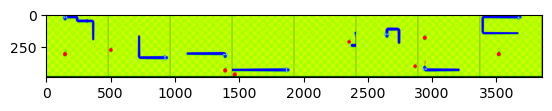

In [7]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images[0].dtype)
imshow(torchvision.utils.make_grid(images))
# print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [8]:
model = torchvision.models.efficientnet_v2_s()
model.classifier = torch.nn.Linear(in_features = 1280, out_features = 5)
model = model.to("cuda")


criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# Training

In [9]:
epoch_number = 30
loss_container = []

for epoch in range(epoch_number):  # loop over the dataset multiple times
    running_loss = 0.0
    pbar = tqdm(trainloader, position = 0, leave = True)
    for data in (pbar):
        pbar.set_description("Epoch: {}/{}".format(epoch,epoch_number))
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print("Current Loss: " + str(running_loss))
    # myTelebot.telegram_bot_sendtext("Current Loss: " + str(running_loss))
    loss_container.append(running_loss)
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0

print('Finished Training')

Epoch: 0/30: 100%|██████████| 363/363 [01:36<00:00,  3.76it/s]


Current Loss: 524.2544876337051


Epoch: 1/30: 100%|██████████| 363/363 [01:34<00:00,  3.86it/s]


Current Loss: 443.760311126709


Epoch: 2/30: 100%|██████████| 363/363 [01:33<00:00,  3.87it/s]


Current Loss: 400.450434923172


Epoch: 3/30: 100%|██████████| 363/363 [01:33<00:00,  3.86it/s]


Current Loss: 373.2757899463177


Epoch: 4/30: 100%|██████████| 363/363 [01:34<00:00,  3.86it/s]


Current Loss: 352.6323158144951


Epoch: 5/30: 100%|██████████| 363/363 [01:34<00:00,  3.86it/s]


Current Loss: 333.52301865816116


Epoch: 6/30: 100%|██████████| 363/363 [01:33<00:00,  3.87it/s]


Current Loss: 305.88421051204205


Epoch: 7/30: 100%|██████████| 363/363 [01:33<00:00,  3.86it/s]


Current Loss: 294.7516614496708


Epoch: 8/30: 100%|██████████| 363/363 [01:33<00:00,  3.87it/s]


Current Loss: 278.7963772341609


Epoch: 9/30: 100%|██████████| 363/363 [01:33<00:00,  3.87it/s]


Current Loss: 258.4900580495596


Epoch: 10/30: 100%|██████████| 363/363 [01:37<00:00,  3.72it/s]


Current Loss: 242.0988137871027


Epoch: 11/30: 100%|██████████| 363/363 [01:37<00:00,  3.73it/s]


Current Loss: 226.77736995369196


Epoch: 12/30: 100%|██████████| 363/363 [01:36<00:00,  3.76it/s]


Current Loss: 203.2871857136488


Epoch: 13/30: 100%|██████████| 363/363 [01:33<00:00,  3.88it/s]


Current Loss: 207.71170542389154


Epoch: 14/30: 100%|██████████| 363/363 [01:35<00:00,  3.82it/s]


Current Loss: 182.38062293827534


Epoch: 15/30: 100%|██████████| 363/363 [01:33<00:00,  3.86it/s]


Current Loss: 178.62743132561445


Epoch: 16/30: 100%|██████████| 363/363 [01:33<00:00,  3.87it/s]


Current Loss: 159.62804266437888


Epoch: 17/30: 100%|██████████| 363/363 [01:34<00:00,  3.83it/s]


Current Loss: 146.060030316934


Epoch: 18/30: 100%|██████████| 363/363 [01:33<00:00,  3.88it/s]


Current Loss: 138.3276017718017


Epoch: 19/30: 100%|██████████| 363/363 [01:32<00:00,  3.93it/s]


Current Loss: 118.88477876782417


Epoch: 20/30: 100%|██████████| 363/363 [01:31<00:00,  3.95it/s]


Current Loss: 114.3236033320427


Epoch: 21/30: 100%|██████████| 363/363 [01:31<00:00,  3.95it/s]


Current Loss: 111.52466252446175


Epoch: 22/30: 100%|██████████| 363/363 [01:31<00:00,  3.97it/s]


Current Loss: 95.55473313294351


Epoch: 23/30: 100%|██████████| 363/363 [01:31<00:00,  3.95it/s]


Current Loss: 89.056626169011


Epoch: 24/30: 100%|██████████| 363/363 [01:32<00:00,  3.92it/s]


Current Loss: 88.90480348840356


Epoch: 25/30: 100%|██████████| 363/363 [01:33<00:00,  3.89it/s]


Current Loss: 79.13154951576144


Epoch: 26/30: 100%|██████████| 363/363 [01:32<00:00,  3.92it/s]


Current Loss: 85.04069460555911


Epoch: 27/30: 100%|██████████| 363/363 [01:33<00:00,  3.89it/s]


Current Loss: 63.02922953478992


Epoch: 28/30: 100%|██████████| 363/363 [01:32<00:00,  3.94it/s]


Current Loss: 50.41857580537908


Epoch: 29/30: 100%|██████████| 363/363 [01:32<00:00,  3.91it/s]

Current Loss: 60.77872428717092
Finished Training


[524.2544876337051, 443.760311126709, 400.450434923172, 373.2757899463177, 352.6323158144951, 333.52301865816116, 305.88421051204205, 294.7516614496708, 278.7963772341609, 258.4900580495596, 242.0988137871027, 226.77736995369196, 203.2871857136488, 207.71170542389154, 182.38062293827534, 178.62743132561445, 159.62804266437888, 146.060030316934, 138.3276017718017, 118.88477876782417, 114.3236033320427, 111.52466252446175, 95.55473313294351, 89.056626169011, 88.90480348840356, 79.13154951576144, 85.04069460555911, 63.02922953478992, 50.41857580537908, 60.77872428717092]


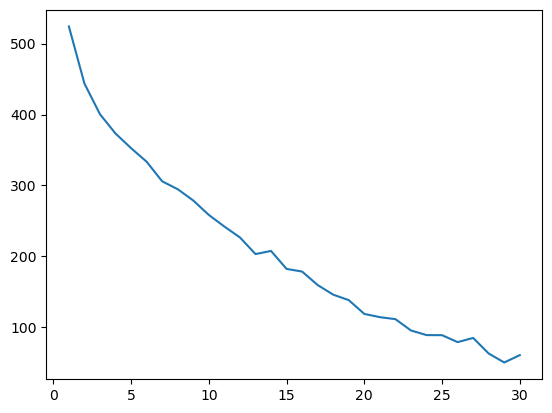

In [10]:
print(loss_container)
plt.plot(np.linspace(1, epoch_number, epoch_number).astype(int), loss_container)

In [11]:
gc.collect()
torch.cuda.empty_cache()

# Save Model Weights

In [12]:
PATH = 'models/efficientnet_s_snake.pth'
torch.save(model.state_dict(), PATH)

# Test and Inference

In [13]:
saved_model = torchvision.models.efficientnet_v2_s()
saved_model.classifier = torch.nn.Linear(in_features = 1280, out_features = 5)
saved_model.load_state_dict(torch.load(PATH))
saved_model = saved_model.to("cuda")
saved_mode = saved_model.eval()



In [14]:
saved_model = torchvision.models.efficientnet_v2_s()
saved_model.classifier = torch.nn.Linear(in_features = 1280, out_features = 5)
saved_model.load_state_dict(torch.load("models/efficientnet_s_snake.pth"))
saved_model.to("cuda")
saved_model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


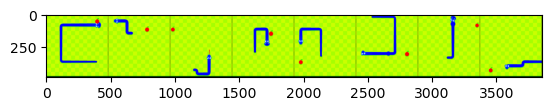

tensor([2, 0, 1, 3, 0, 2, 3, 4], device='cuda:0')


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
images = images.to("cuda")
labels = labels.to("cuda")

outputs = saved_model(images)
_, predicted = torch.max(outputs, 1)



print(predicted)

In [16]:
correct = 0
total = 0
with torch.no_grad():
  for data in tqdm(trainloader, position = 0, leave = True):
    images,labels = data
    images = images.to("cuda")
    labels = labels.to("cuda")

    outputs = saved_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  
print(f'\n Accuracy of the network on the training images: {100 * correct // total} %')

100%|██████████| 363/363 [00:39<00:00,  9.20it/s]


 Accuracy of the network on the training images: 89 %


In [17]:
correct = 0
total = 0
with torch.no_grad():
  for data in tqdm(testloader, position = 0, leave = True):
    images,labels = data
    images = images.to("cuda")
    labels = labels.to("cuda")

    outputs = saved_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  
print(f'\n Accuracy of the network on the test images: {100 * correct // total} %')

100%|██████████| 91/91 [00:10<00:00,  9.02it/s]


 Accuracy of the network on the test images: 73 %
